In [18]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from prophet import Prophet

1. Selección del dataset:
- Utiliza un dataset de series temporales de Kaggle, como el de «Air Quality Prediction» o cualquier otro relacionado con predicción de demanda, precios de acciones, etc. Puedes elegir el dataset que más se relacione con tus intereses.
- Enlace sugerido: [Air Quality Prediction](https://www.kaggle.com/competitions/air-quality-prediction)



In [19]:
data_path_train='../ejercicios_core/data/data_date.csv'

df = utils.cargar_datos(data_path_train)
df

,Date,Country,Status,AQI Value
0,2022-07-21,Albania,Good,14
1,2022-07-21,Algeria,Moderate,65
2,2022-07-21,Andorra,Moderate,55
3,2022-07-21,Angola,Unhealthy for Sensitive Groups,113
4,2022-07-21,Argentina,Moderate,63
...,...,...,...,...
16648,2024-12-12,United States of America,Unhealthy for Sensitive Groups,105
16649,2024-12-12,Uzbekistan,Moderate,100
16650,2024-12-12,Vatican,Moderate,53
16651,2024-12-12,Venezuela,Good,2


2. Preprocesamiento de datos:
- Realiza una exploración inicial de la serie temporal, incluyendo la visualización de la tendencia y la estacionalidad si es aplicable.
- Realiza un escalado de los datos, ya que las redes neuronales recurrentes se benefician de que los datos estén en un rango similar.


In [20]:
utils.exploracion_inicial(df)

Informacion del dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16653 entries, 0 to 16652
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       16653 non-null  object
 1   Country    16653 non-null  object
 2   Status     16653 non-null  object
 3   AQI Value  16653 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 520.5+ KB
None
         Date    Country                          Status  AQI Value
0  2022-07-21    Albania                            Good         14
1  2022-07-21    Algeria                        Moderate         65
2  2022-07-21    Andorra                        Moderate         55
3  2022-07-21     Angola  Unhealthy for Sensitive Groups        113
4  2022-07-21  Argentina                        Moderate         63
nÚltimas 5 filas del DataFrame:
             Date                   Country                          Status  \
16648  2024-12-12  United States of America  Unhealthy for

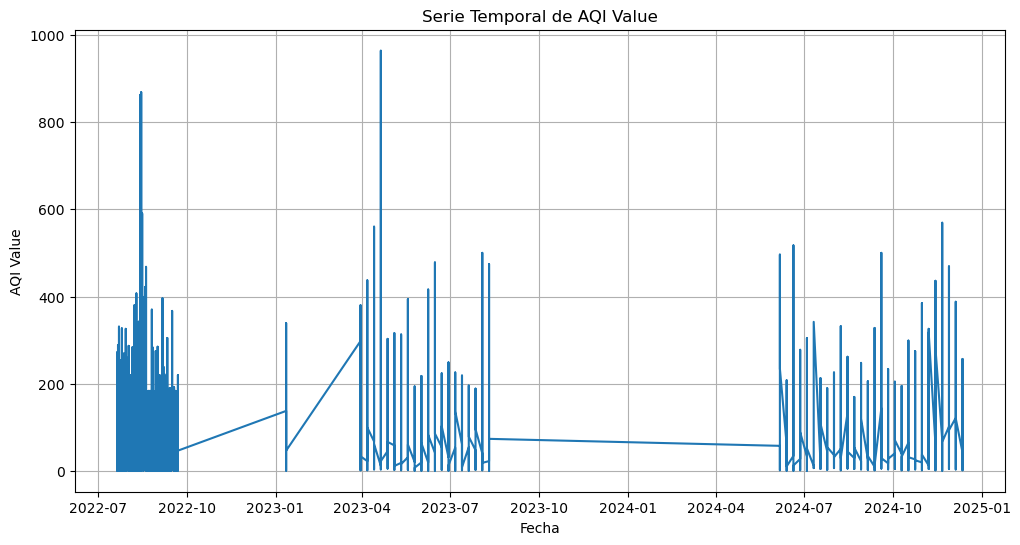

In [21]:
# Convertir la columna 'Date' a formato datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ordenar por fecha si es necesario
data = df.sort_values(by='Date')

# Seleccionar la columna relevante para la serie temporal
data = data[['Date', 'AQI Value']]

# Establecer la fecha como índice
data.set_index('Date', inplace=True)

# Visualización inicial de la serie temporal
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['AQI Value'])
plt.title('Serie Temporal de AQI Value')
plt.xlabel('Fecha')
plt.ylabel('AQI Value')
plt.grid()
plt.show()

In [22]:
# Escalado de los datos con MinMaxScaler ya que escala a un rango específico, conservando la forma de la distribución original, para este caso se considera la columna AQI Value.
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['AQI Value']])

3. Implementación de RNN con LSTM:
- Implementa una red LSTM para predecir la serie temporal. Utiliza una arquitectura simple con una capa LSTM y una capa densa para predecir el valor futuro de la serie temporal.
- Asegúrate de dividir los datos en conjuntos de entrenamiento y prueba, utilizando las primeras partes de la serie para entrenar el modelo y las últimas partes para probar la precisión de las predicciones.


In [23]:
# Preparación de los datos para la LSTM
def create_dataset(data, look_back=3): #look_back=30  Número por defecto de días para predecir el siguiente valor
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 30 # Número de días para predecir el siguiente valor
X, y = create_dataset(data_scaled, look_back)

In [24]:
# Dividir en entrenamiento y prueba (80-20)
# Dividir en conjuntos de entrenamiento y prueba
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [25]:
#Construir el modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

c:\Users\ENRIF\anaconda3\envs\bootcamp_coding_dojo\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 2/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 3/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 4/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 5/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 6/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 7/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 8/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 9/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 10/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 11/20
416/416 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 12/20
416/416 ━━━━━━━━━━

In [26]:
# Predicción con LSTM
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


RMSE del modelo LSTM: 49.78


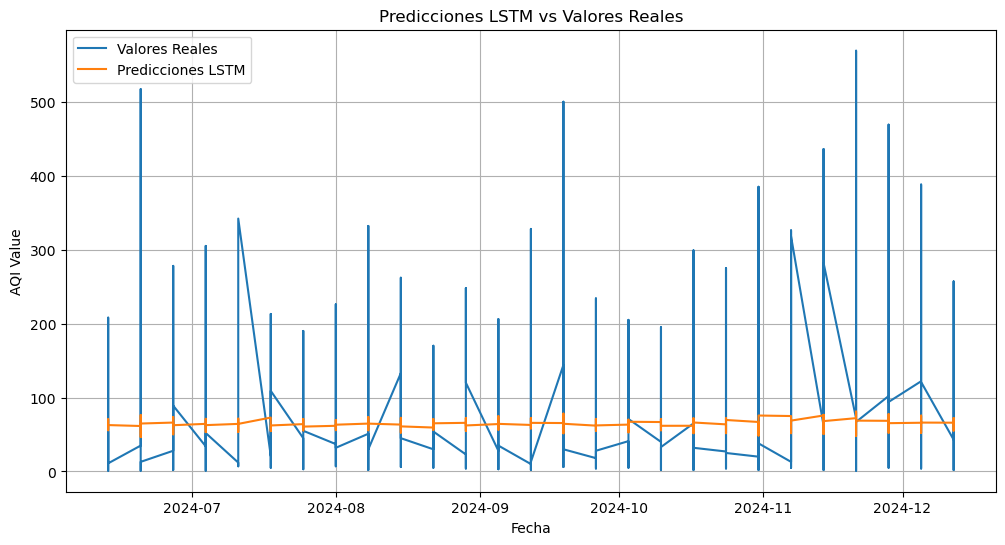

In [27]:
# Evaluación del modelo LSTM
rmse_lstm = sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"RMSE del modelo LSTM: {rmse_lstm:.2f}")

# Visualización de predicciones LSTM
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_rescaled, label='Valores Reales')
plt.plot(data.index[-len(y_test):], y_pred_rescaled, label='Predicciones LSTM')
plt.title('Predicciones LSTM vs Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('AQI Value')
plt.legend()
plt.grid()
plt.show()

4. Uso de Prophet:
- Instala y utiliza Prophet para predecir la misma serie temporal. Prophet es un modelo que maneja fácilmente tendencias y estacionalidades, por lo que es ideal para comparación con redes recurrentes.
- Entrena Prophet con los mismos datos que utilizaste para la red LSTM y realiza predicciones en el conjunto de prueba.


In [28]:
# Implementación de Prophet
data_prophet = data.reset_index()
data_prophet.columns = ['ds', 'y']  # Prophet requiere estas columnas
prophet_model = Prophet()
prophet_model.fit(data_prophet)

00:14:38 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing


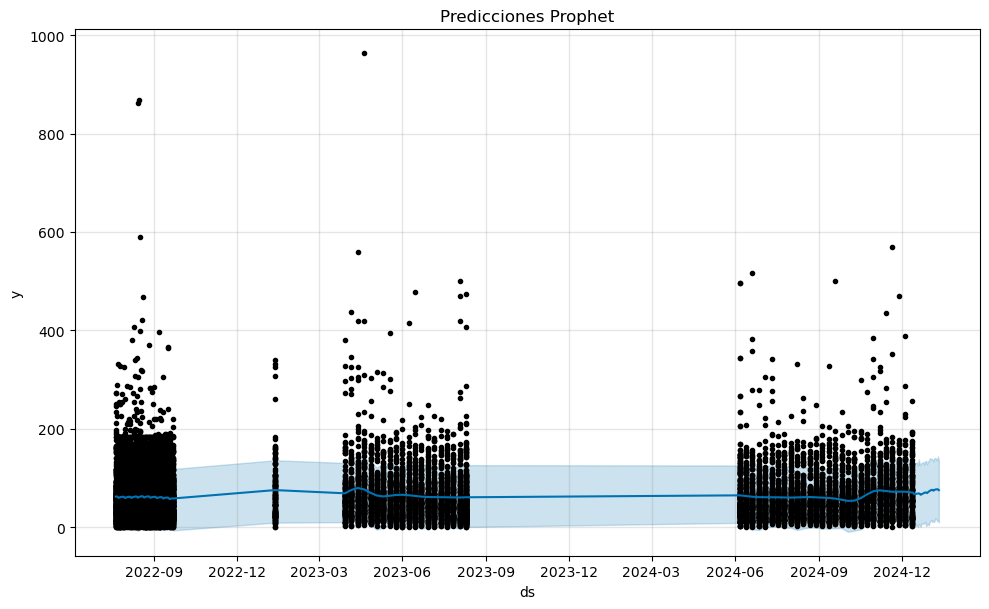

In [29]:
# Predicciones con Prophet
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Visualización de predicciones Prophet
prophet_model.plot(forecast)
plt.title('Predicciones Prophet')
plt.show()

In [30]:
# Comparación de predicciones
forecast_actual = forecast[['ds', 'yhat']].tail(len(y_test))
forecast_actual['yhat_rescaled'] = scaler.inverse_transform(forecast_actual['yhat'].values.reshape(-1, 1))
rmse_prophet = sqrt(mean_squared_error(y_test_rescaled, forecast_actual['yhat_rescaled']))
print(f"RMSE del modelo Prophet: {rmse_prophet:.2f}")

ValueError: Found input variables with inconsistent numbers of samples: [3325, 143]

In [34]:
# Asegurarse de que y_test esté en formato DataFrame con una columna 'ds' para las fechas
y_test_df = pd.DataFrame(y_test, columns=['y'])

# Si y_test no tiene la columna 'ds' (fechas), asignar las fechas del DataFrame original
y_test_df['ds'] = df.iloc[-len(y_test):]['Date'].reset_index(drop=True)

# Verificar las primeras fechas
print(y_test_df.head())

# Verificar el rango de fechas en y_test
start_date = y_test_df['ds'].iloc[0]
end_date = y_test_df['ds'].iloc[-1]

# Generar el rango de fechas que cubre todo y_test
future_dates = prophet_model.make_future_dataframe(data_prophet, periods=(end_date - start_date).days)
forecast = prophet_model.predict(future_dates)

# Asegúrate de filtrar las fechas de las predicciones generadas
forecast_test = forecast[['ds', 'yhat']].iloc[-len(y_test):].reset_index(drop=True)

# Filtrar las predicciones por las fechas de y_test
forecast_test = forecast_test[forecast_test['ds'].isin(y_test_df['ds'])]

# Reescalar las predicciones
forecast_test['yhat_rescaled'] = scaler.inverse_transform(forecast_test['yhat'].values.reshape(-1, 1))

# Verificar que las longitudes coincidan
print(f"Longitud de y_test_df: {len(y_test_df)}")
print(f"Longitud de forecast_test: {len(forecast_test)}")

# Calcular RMSE
rmse_prophet = sqrt(mean_squared_error(y_test_df['y'], forecast_test['yhat_rescaled']))
print(f"RMSE del modelo Prophet: {rmse_prophet:.2f}")


          y         ds
0  0.054054 2024-06-13
1  0.020790 2024-06-13
2  0.000000 2024-06-13
3  0.034304 2024-06-13
4  0.015593 2024-06-13


TypeError: Prophet.make_future_dataframe() got multiple values for argument 'periods'